# Deep Learning Locust Prediction in Ethiopia using Remote Sensing Data

### Semester Project SS 2021 @ Advanced Programming for Remote Sensing
#### Julius-Maximilians-Universität Würzburg

This is a semester project for the course advanced programming aiming to use deep learning model and real-time climate variables to predict the emergence of locust swarms using data from Locust hub.

***
## Description

The post-processed data needs to be inspected before transforming into the training and testing dataset. In this notebook, both Landsat series and FLDAS data are being examined with exploratory data analysis. The questions aim to be answered included:

**1) How outliners are distributed in the datasets for different variables?**

**2) Are the variables normalized distributed? Do they need to be transform?**

**3) What are the potential of different variables being used to predict presence? What are more relevance and what are less?**

**Tasks:**
* Inspect Landsat and Climate Data
* Inspect distribution patterns
* Inspect outliners
***

#### Import Libraries

In [1]:
#@title Load Python libraries

! pip install pandas fiona shapely pyproj rtree
! pip install alpha_vantage -q
! pip install regions
! pip install geopandas

# pip install numpy
import numpy as np


# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import regions

import pandas as pd
import seaborn as sns
import datetime

#pip install matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.animation as animation

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

from geopandas.tools import sjoin

print("All libraries loaded")

     |████████████████████████████████| 15.4 MB 33 kB/s 
     |████████████████████████████████| 6.3 MB 35.1 MB/s 
     |████████████████████████████████| 994 kB 42.8 MB/s 
     |████████████████████████████████| 1.3 MB 12.3 MB/s 
     |████████████████████████████████| 294 kB 49.4 MB/s 
     |████████████████████████████████| 142 kB 66.7 MB/s 
     |████████████████████████████████| 744 kB 7.3 MB/s 
     |████████████████████████████████| 994 kB 7.5 MB/s 
All libraries loaded


#### Set up

In [2]:
config = {
    #"alpha_vantage": {
    #    "key": "YOUR_API_KEY", # Claim your free API key here: https://www.alphavantage.co/support/#api-key
     #   "symbol": "IBM",
     #   "outputsize": "full",
     #   "key_adjusted_close": "5. adjusted close",
    #},
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

## Locust Presence Data inspection

First, we would like to look into the distribution of locust outbreaks in the records from Locust Hub. Are there already patterns we can observed?

#### Import data

In [4]:
# select the "locust_points.csv" from your local project drive
from google.colab import files
uploaded = files.upload()

# see the head of the dataframe
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['locust_points.csv']))

Saving locust_points.csv to locust_points.csv


In [5]:
df.head()

,X,Y,Year,Month,PRESENCE
0,12.953325,8.830587,1985.0,1.0,0.0
1,44.172727,1.561905,1985.0,1.0,0.0
2,13.939077,14.999228,1985.0,1.0,0.0
3,34.682094,3.212091,1985.0,1.0,0.0
4,41.772839,1.033824,1985.0,1.0,0.0


Here we can see around 50% of the data are presence data which is what we want for training binary classification later on.

In [6]:
df.PRESENCE.describe()

count    69876.000000
mean         0.467628
std          0.498955
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: PRESENCE, dtype: float64

Get a summary group by years of records.

In [8]:
summary = df.groupby('Year').describe().unstack(1)

In [20]:
pd.set_option('display.max_rows', 1000)

In [ ]:
summary.PRESENCE

## Locust Swarms Distribution

### Yearly trend

Now we can look at the distribution of the locust records. It can be seen that the records are not distributed evenly across years, with some years sharing significant proportion of records, such as in 1988 and 2004.

Text(0.5, 1.0, 'Distribution of locust presence')

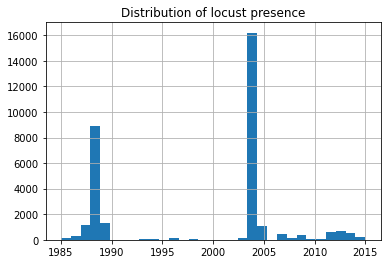

In [26]:
bins = 2015-1985+1
df.where(df.PRESENCE == 1).Year.hist(bins=bins)
plt.title("Year Distribution of locust presence")

### Seasonal pattern

We can look at the distribution patterns for each month. It also can be seen that locust occurred not evenly throughout the year, but concentrated in the summer months (September to December), which fits the behavior patterns of locust and mostly due to the specific weather/climatic conditions during summer which will be captured in the FLDAS dataset for training.

Text(0.5, 1.0, 'Month Distribution of locust presence')

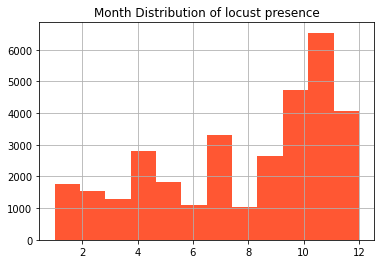

In [30]:
df.where(df.PRESENCE == 1).Month.hist(bins=12, color="#FF5733")
plt.title("Month Distribution of locust presence")

## FLDAS Dataset

In [2]:
# select the "FLDAS_05_extracted.csv" from your local project drive
from google.colab import files
uploaded = files.upload()

# see the head of the dataframe
import io
import pandas as pd

df_clim = pd.read_csv(io.BytesIO(uploaded['FLDAS_05_extracted.csv']))

In [56]:
df_clim.head()

,Unnamed: 0,Month,PRESENCE,X,Y,Year,evap,heatnet,humid,id,latheat,prep,pressure,radtemp,runoff,soilheat,soilmoi_10cm,soilmoi_1m,soilmoi_2m,soilmoi_40cm,soiltemp_10cm,soiltemp_1m,soiltemp_2m,soiltemp_40cm,surfacetemp,windspeed
0,28539,1,0.0,17.527132,-4.781256,2005,0.000051,15.859563,0.014929,24025,128.641953,0.000039,96477.648438,298.647400,1.293975e-06,0.256700,0.351020,0.341951,0.321602,0.350645,298.601746,298.478638,298.468109,298.498199,299.921814,2.260092
1,28540,1,0.0,32.655656,2.130108,2005,0.000012,97.880386,0.009365,24031,29.172043,0.000005,89257.445312,301.624847,7.139084e-08,3.121166,0.211376,0.329741,0.355846,0.323129,301.270447,298.747925,297.440491,299.850433,299.114136,5.025097
2,28541,1,0.0,32.655656,2.130108,2005,0.000012,97.880386,0.009365,24034,29.172043,0.000005,89257.445312,301.624847,7.139084e-08,3.121166,0.211376,0.329741,0.355846,0.323129,301.270447,298.747925,297.440491,299.850433,299.114136,5.025097
3,28542,1,0.0,32.655656,2.130108,2005,0.000012,97.880386,0.009365,24085,29.172043,0.000005,89257.445312,301.624847,7.139084e-08,3.121166,0.211376,0.329741,0.355846,0.323129,301.270447,298.747925,297.440491,299.850433,299.114136,5.025097
4,28543,1,0.0,42.807553,1.952849,2005,0.000012,116.081398,0.011569,24058,30.393681,0.000000,98770.953125,302.539673,0.000000e+00,1.938225,0.158357,0.244148,0.356709,0.236170,302.355560,301.118927,300.552887,301.696228,300.503479,7.459985


Remove the unneeded id columns for analysis

In [57]:
df_clim = df_clim.drop(columns='Unnamed: 0')

In [58]:
cols = set(df_clim.columns) - {'id','X','Y','PRESENCE','Year','Month'}
df_rm_id = df[list(cols)]
df_rm_id.describe() # check patterns

,heatnet,soilmoi_10cm,soiltemp_40cm,prep,surfacetemp,runoff,soilmoi_2m,soiltemp_2m,pressure,soiltemp_1m,radtemp,evap,humid,windspeed,latheat,soilheat,soiltemp_10cm,soilmoi_40cm,soilmoi_1m
count,2287.000000,2287.000000,2287.000000,2.287000e+03,2287.000000,2.287000e+03,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2.287000e+03,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000,2287.000000
mean,46.868867,0.239015,292.504258,1.531977e-05,291.832729,1.077050e-06,0.278703,293.247110,94111.325780,292.777181,292.315623,1.462379e-05,0.007911,5.138095,36.609712,-0.501871,292.362106,0.281407,0.271246
std,43.053805,0.082324,9.170722,2.594105e-05,8.946090,4.069321e-06,0.108422,7.422036,4139.590622,8.495046,9.739459,1.865392e-05,0.004807,1.721159,46.641262,2.619988,9.606137,0.081119,0.090067
min,-24.198736,0.139127,274.513367,0.000000e+00,276.232086,0.000000e+00,0.080000,278.332245,75405.453125,276.177368,272.005707,-8.233447e-08,0.002122,1.366593,-0.205919,-8.783843,273.100159,0.080000,0.080000
25%,12.521558,0.167847,282.020844,9.309582e-08,281.915497,1.143095e-10,0.257927,284.987762,91125.179688,283.135788,281.018173,1.388760e-06,0.003421,4.332356,3.473288,-2.984522,281.204468,0.226599,0.201031
50%,30.348286,0.222765,296.229614,3.461442e-06,295.586426,2.936063e-08,0.305480,296.317535,94533.882812,296.118286,296.338989,5.742143e-06,0.006904,5.287756,14.361101,0.230700,296.283691,0.297807,0.295903
75%,76.841522,0.270551,299.465897,1.486770e-05,299.257980,3.564659e-07,0.344227,298.991569,97075.468750,299.371033,299.598495,2.140140e-05,0.012302,6.202289,53.524912,1.102292,299.559631,0.324955,0.324055
max,165.771179,0.432180,311.011383,2.223165e-04,310.558350,9.053892e-05,0.467676,309.240204,102718.242188,310.361298,312.048676,6.799345e-05,0.019825,15.739703,170.051605,6.788416,311.824829,0.435038,0.443154


In [61]:
df_rm_id.columns

Index(['Month', 'PRESENCE', 'X', 'Y', 'Year', 'evap', 'heatnet', 'humid', 'id',
       'latheat', 'prep', 'pressure', 'radtemp', 'runoff', 'soilheat',
       'soilmoi_10cm', 'soilmoi_1m', 'soilmoi_2m', 'soilmoi_40cm',
       'soiltemp_10cm', 'soiltemp_1m', 'soiltemp_2m', 'soiltemp_40cm',
       'surfacetemp', 'windspeed'],
      dtype='object')

Convert the dataframe from wide to long for boxplot with groupped parameters

In [65]:
df_long = pd.melt(df_clim, "PRESENCE", var_name="climateVar", value_name="value")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


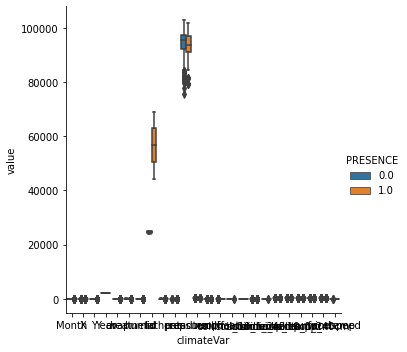

In [66]:
# Plot all parameters
# As the range of different parameters are quite different, 
#we can extract some important groups of variables for further inspection
sns.factorplot("climateVar", hue="PRESENCE", y="value", data=df_long, kind="box")

## Significant FLDAS Climate Variables

From the boxplot below, it can be seen that multiple climate variables, such as soil moisture and temperature, seem to show quite distinct differences for presence and absence data points. Among all variables, soil temperature are the most distinct, with very clear differences between presence and absence group at all depths (10cm, 40cm, 1m, and 2m).

* ### Evaporation

In [71]:
# Looking into evaporation
df_evap = df_clim[['PRESENCE','evap']]
evap_long = pd.melt(df_evap, "PRESENCE", var_name="climateVar", value_name="value")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


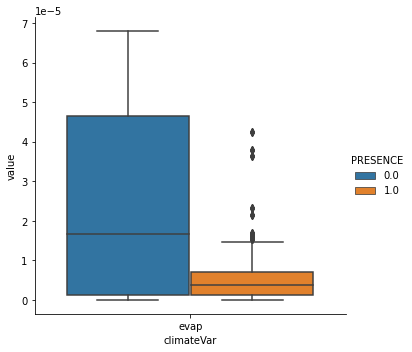

In [73]:
sns.factorplot("climateVar", hue="PRESENCE", y="value", data=evap_long, kind="box")
plt.title("Distribution of Evaporation")

* ### Soil Moisture

In [74]:
# Let's do the same for soil moisture
df_moi = df_clim[['PRESENCE','soilmoi_10cm', 'soilmoi_40cm','soilmoi_1m', 'soilmoi_2m']]
moi_long = pd.melt(df_moi, "PRESENCE", var_name="climateVar", value_name="value")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


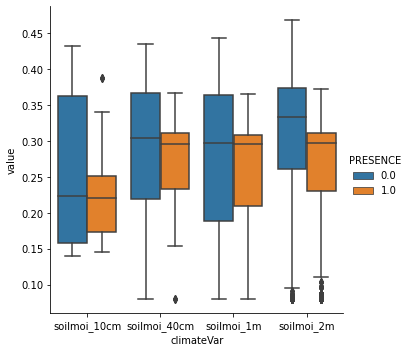

In [75]:
sns.factorplot("climateVar", hue="PRESENCE", y="value", data=moi_long, kind="box")
plt.title("Distribution of Soil Moisture")

* ### Soil Temperature

In [76]:
# Same for soil temperature
df_temp = df_clim[['PRESENCE','soiltemp_10cm', 'soiltemp_1m', 'soiltemp_2m', 'soiltemp_40cm', 'surfacetemp']]
temp_long = pd.melt(df_temp, "PRESENCE", var_name="climateVar", value_name="value")

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


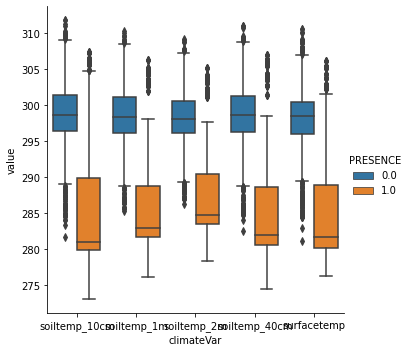

In [77]:
sns.factorplot("climateVar", hue="PRESENCE", y="value", data=temp_long, kind="box")
plt.title("Distribution of Soil Temperature")

## Data Transformation

In order to inspect the distribution of the data, histograms are plotted. As the random points area drawn from different African countries during different months, with the limited sample size normality would not be achieved. But for some variables (i.e. evap, runoff, latheat) it can be seen that the range is in the exponentially scale and need to be transform with log.

In [3]:
df_clim.columns

In [ ]:
df_hist = df_clim.where(df_clim.PRESENCE == 1).drop(columns=['Month', 'PRESENCE', 'X', 'Y', 'Year', 'id'])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df_hist, df_hist.columns[0:4], 2, 2)

In [ ]:
draw_histograms(df_hist, df_hist.columns[5:9], 2, 2)

In [ ]:
draw_histograms(df_hist, df_hist.columns[10:14], 2, 2)

In [ ]:
draw_histograms(df_hist, df_hist.columns[15:19], 2, 2)

## Landsat Spectral Data

similarly, we can look at the distribution of spectral values in the Landsat series.

In [ ]:
# select the "locust_points.csv" from your local project drive
from google.colab import files
uploaded = files.upload()

# see the head of the dataframe
import io
import pandas as pd

df = pd.read_csv(io.BytesIO(uploaded['Landsat_04_extracted.csv']))

In [ ]:
df = df.drop(columns="Unnamed: 0")

In [ ]:
cols = set(df.columns) - {'id','X','Y','Year','Month'}
df_rm_id = df[list(cols)]

In [ ]:
df_long = pd.melt(df_rm_id, "PRESENCE", var_name="SpectralValues", value_name="value")

In [ ]:
ls_box = sns.factorplot("SpectralValues", hue="PRESENCE", y="value", data=df_long, kind="box")
ls_box.set(ylim=(0, 8000))